# Importing the Libraries

In [2]:
#importing libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


# Loading the dataset

In [62]:
# Reading the csv file 
df = pd.read_csv('kaggle_train.csv')
df.shape

(242, 320)

In [63]:
# Creating the head of the dataframe
df.head()

,ID,Labels,ACAN,AGER,ALPK1,ANKRD17,APOB,APPL1,APPL2,ARRB2,...,UBE2N,UBE2V1,UBQLN1,UFD1,UNC93B1,USP17L2,VCAN,WDFY1,XIAP,ZCCHC3
0,TCGA-JW-A5VG,0,13.6584,88.0205,402.5420,1424.2625,3.7940,1001.2330,508.0148,567.2010,...,2437.6363,3413.2107,4135.4453,950.0104,1434.1269,0.0000,31.8695,923.0769,1046.0021,819.1217
1,TCGA-HG-A2PA,0,22.0844,86.3807,690.4861,2226.3285,20.4071,486.9744,1448.0640,651.9083,...,2153.9253,1817.3762,3426.4325,1380.1196,815.7241,0.0000,1651.0166,1473.7825,1618.8684,615.8465
2,TCGA-C5-A0TN,0,32.7422,53.0820,128.4882,1073.0497,0.0000,654.8431,492.6206,512.9604,...,3122.4110,3720.6995,3000.3721,2681.3791,1429.2447,0.4961,693.5384,477.2417,1064.6161,804.1672
3,TCGA-C5-A1BM,0,22.7975,42.1175,634.0804,3285.5487,0.0000,574.9614,513.9104,1033.2303,...,2663.4467,3217.9212,4131.3756,1178.8640,1018.5471,0.0000,675.0386,1596.5997,1666.1515,402.6275
4,TCGA-EK-A2RA,0,2.5000,134.0625,532.1875,936.5625,0.0000,1933.4375,679.3750,1175.6250,...,1898.4375,3009.1375,2549.3750,1293.1156,744.6875,0.0000,69.0625,1651.5625,1250.3125,982.5000


# Creating X_train and y_train

In [64]:
# put labels into y_train variable
y_train = df["Labels"]
# Drop 'label' and 'ID' columns for creating X_train
X_train = df.drop(labels = ["Labels","ID"],axis = 1) 

# Visualizing the two classes

1    121
0    121
Name: Labels, dtype: int64

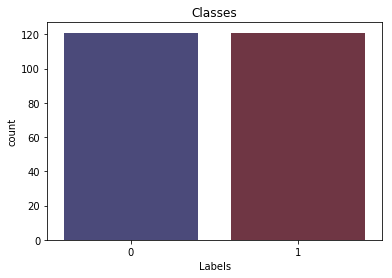

In [65]:
# visualize the classes
#plt.figure(figsize=(15,7))
g = sns.countplot(y_train, palette="icefire")
plt.title("Classes")
y_train.value_counts()

In [66]:
# Normalizing the data
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_train.shape

(242, 318)

# Reshaping the data for the model

In [67]:
# padding the matrix with mean to make 324 columns
X_train = np.pad(X_train, ((0, 0), (3, 3)), 'mean')
X_train.shape

(242, 324)

In [68]:
X_train

array([[-0.0869509 , -0.0869509 , -0.0869509 , ..., -0.0869509 ,
        -0.0869509 , -0.0869509 ],
       [ 0.1445462 ,  0.1445462 ,  0.1445462 , ...,  0.1445462 ,
         0.1445462 ,  0.1445462 ],
       [-0.12896915, -0.12896915, -0.12896915, ..., -0.12896915,
        -0.12896915, -0.12896915],
       ...,
       [ 0.02179964,  0.02179964,  0.02179964, ...,  0.02179964,
         0.02179964,  0.02179964],
       [-0.11876906, -0.11876906, -0.11876906, ..., -0.11876906,
        -0.11876906, -0.11876906],
       [-0.01690106, -0.01690106, -0.01690106, ..., -0.01690106,
        -0.01690106, -0.01690106]])

In [69]:
# another technique for reshaping 
# X_train = np.concatenate([np.zeros([242,3]),X_train,np.zeros([242,3])], axis=1)
# X_train.shape

In [70]:
# Reshaping it to the form of input for CNN
X_train = X_train.reshape(X_train.shape[0], 18, 18, 1)
X_train.shape

(242, 18, 18, 1)

In [71]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_val shape",Y_val.shape)

x_train shape (217, 18, 18, 1)
x_val shape (25, 18, 18, 1)
y_train shape (217,)
y_val shape (25,)


# Model Architecture

In [72]:
model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (18,18,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))

In [73]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [74]:
# Compile the model
model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

In [75]:
# Fit the model
history = model.fit(X_train,
                    Y_train,
                    epochs = 30, 
                    validation_data = (X_val,Y_val))

Train on 217 samples, validate on 25 samples
Epoch 1/30
217/217 [==============================] - 0s 2ms/step - loss: 0.7387 - accuracy: 0.4700 - val_loss: 0.7003 - val_accuracy: 0.5200
Epoch 2/30
217/217 [==============================] - 0s 414us/step - loss: 0.7719 - accuracy: 0.4700 - val_loss: 0.6673 - val_accuracy: 0.6400
Epoch 3/30
217/217 [==============================] - 0s 410us/step - loss: 0.6879 - accuracy: 0.5530 - val_loss: 0.6711 - val_accuracy: 0.5600
Epoch 4/30
217/217 [==============================] - 0s 404us/step - loss: 0.6987 - accuracy: 0.5253 - val_loss: 0.6766 - val_accuracy: 0.6000
Epoch 5/30
217/217 [==============================] - 0s 485us/step - loss: 0.6985 - accuracy: 0.5484 - val_loss: 0.6788 - val_accuracy: 0.6000
Epoch 6/30
217/217 [==============================] - 0s 460us/step - loss: 0.7082 - accuracy: 0.5300 - val_loss: 0.6826 - val_accuracy: 0.6000
Epoch 7/30
217/217 [==============================] - 0s 460us/step - loss: 0.7001 - accuracy

# Plotting the curve for losses

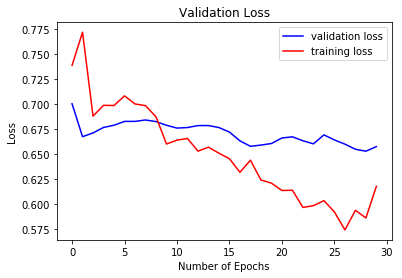

In [76]:
# Plotting the loss and accuracy curves for training and validation data
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['loss'], color='r', label="training loss")
plt.title("Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Creating Test Dataset

In [77]:
# Reading the csv file 
df_test = pd.read_csv('kaggle_test.csv')
print(df_test.shape)
df_test.head()

(62, 319)


,ID,ACAN,AGER,ALPK1,ANKRD17,APOB,APPL1,APPL2,ARRB2,ASGR1,...,UBE2N,UBE2V1,UBQLN1,UFD1,UNC93B1,USP17L2,VCAN,WDFY1,XIAP,ZCCHC3
0,1001,91.3265,132.5226,331.5548,1658.7666,0.0000,1068.6189,571.2868,699.8387,9.4305,...,1525.2513,3320.8537,2817.7193,1397.1957,367.7876,0.4963,699.3424,995.6570,1219.0098,840.7991
1,1002,17.5971,183.2524,558.8592,2321.6019,0.6068,929.0049,783.9806,1039.4417,27.3058,...,2489.6845,2102.5485,3799.1505,906.5534,1187.5000,0.0000,1967.2330,1529.7330,1083.1311,510.3155
2,1003,120.9309,221.8022,331.8437,891.7940,0.0000,309.4915,403.4852,1430.5385,49.8625,...,1760.6628,4822.9092,3718.4831,1907.9521,1732.0061,0.0000,1190.9692,1156.5812,710.6842,689.4783
3,1004,12.0930,41.8605,886.5116,2216.7442,0.0000,792.5581,1012.0930,637.2093,3.7209,...,1872.5581,2342.0093,3280.9302,1115.3116,773.0233,0.0000,63.2558,1065.1163,1385.1163,563.7209
4,1005,84.0622,34.4995,145.7726,1266.2779,0.4859,1362.4879,830.9038,1064.1399,85.5199,...,1932.9446,3220.9184,3153.5471,1168.6054,965.5005,0.0000,1168.6103,581.6327,878.5228,607.8717


In [78]:
# Drop 'label' column for creating X_train
X_test = df_test.drop(labels = ["ID"],axis = 1) 

# Normalizing the Test data

In [79]:
# Normalizing the test data
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_test = ss.fit_transform(X_test)
X_test.shape

(62, 318)

In [80]:
# padding the matrix with mean to make 324 columns
X_test = np.pad(X_test, ((0, 0), (3, 3)), 'mean')
X_test.shape

(62, 324)

In [81]:
# Reshaping it to the form of input for CNN
X_test = X_test.reshape(X_test.shape[0], 18, 18, 1)
X_test.shape

(62, 18, 18, 1)

In [134]:
pred = model.predict(X_test)

In [135]:
pred1 = pred

In [83]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve
pred_proba = model.predict_proba(X_val)
#pred_proba = pred_proba[:,1]

fpr, tpr, thresholds = roc_curve(Y_val, pred_proba)

J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f \n' % (best_thresh))

# To labels 
pred = (pred_proba >= best_thresh).astype('int')

print(metrics.classification_report(Y_val, pred))

Best Threshold=0.484946 

              precision    recall  f1-score   support

           0       0.69      0.75      0.72        12
           1       0.75      0.69      0.72        13

    accuracy                           0.72        25
   macro avg       0.72      0.72      0.72        25
weighted avg       0.72      0.72      0.72        25



In [137]:
pred1[pred1>0.484946] = 1
pred1[pred1<=0.484946] = 0

In [138]:
pred1 = pred1.astype(int)

In [99]:
predict = pd.DataFrame(pred1)

In [100]:
lab = df_test.ID

In [101]:
output = pd.concat([lab,predict],axis=1)

In [102]:
output

,ID,0
0,1001,1
1,1002,0
2,1003,1
3,1004,0
4,1005,1
5,1006,0
6,1007,1
7,1008,1
8,1009,1
9,1010,0


In [103]:
output.to_csv('output1.csv', header=['ID','Labels'], index=False)